In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [5]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [6]:
include("../test/data.jl")

generate_pattern_dataset (generic function with 1 method)

In [7]:
copy_data = generate_reversal_dataset(rng);

In [8]:
n_hd = 512;

In [9]:
cb = generate_codebook(rng, n_hd=n_hd);

In [71]:
copy_hd = map_symbols(copy_data, cb);

In [72]:
copy_hd |> size

(1000,)

In [73]:
typeof(copy_hd[1])

Tuple{Matrix{Float64}, Matrix{Float64}}

In [74]:
copy_hd[1][1] |> size

(512, 50)

In [ ]:
function generate_positions(rng, n_hd::Int, n_positions::Int, scale::Real)
    position = random_symbols((n_hd,1), rng)
    scales = scale * (0:n_positions-1) ./ n_positions
    scales = reshape(scales, (1, n_positions))
    movements = scales .* position
    positions = v_bind(ones(n_hd, n_positions) .* position, position .* scales)
    return positions
end

generate_positions (generic function with 1 method)

In [75]:
posn = generate_positions(rng, n_hd, 50, 1.0);

In [76]:
posn |> size

(512, 50)

In [77]:
smo = dropdims(similarity_outer(posn[:,:,1:1], posn[:,:,1:1]), dims=3);

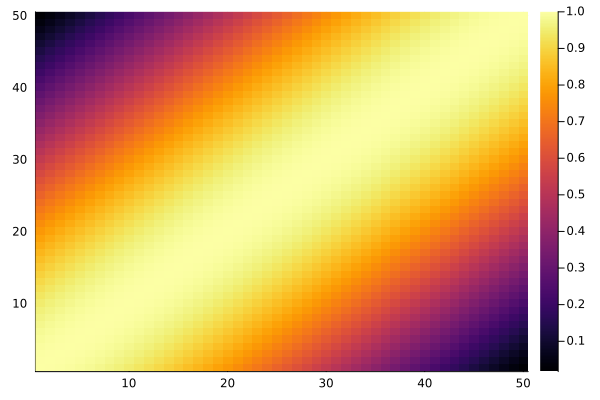

In [78]:
heatmap(smo)

In [79]:
function attach_positions(sentence::Tuple{<:Matrix, <:Matrix}, position_cb::Matrix{<:Real})
    x, y = sentence

    n_hd = size(x,1)
    n_x = size(x,2)
    n_y = size(y,2)

    xform = x -> dropdims(v_bundle((x, position_cb), dims=3), dims=3)

    x = xform(x)
    y = xform(y)

    return (x,y)
end

attach_positions (generic function with 2 methods)

In [80]:
sx, sy = attach_positions(copy_hd[1], posn)

([0.011557519435882568 0.13897221326828 … 0.4350615930557251 0.43950099706649787; -0.38842761516571045 0.008654342889785779 … -0.16534385442733765 -0.16703103661537175; … ; -0.7900009473044541 -0.21201094269752502 … -0.3824817681312561 -0.3863846433162689; 0.24970555305480957 0.17388296842575082 … -0.40813995838165296 -0.4021005702018738], [0.22197020053863525 0.22640960454940795 … -0.6523757703978685 -0.7709116562087205; -0.08435910940170288 -0.08604629158973695 … -0.07064321994781494 -0.47109954237937923; … ; -0.19514375925064087 -0.19904663443565368 … -0.39544607639312745 -0.9812418313700821; 0.30196940898895264 0.30800879716873175 … -0.5422657871246339 -0.45436442613601685])

In [81]:
sx |> size

(512, 50)

In [84]:
sxo = similarity_outer(sx[:,:,1:1], sx[:,:,1:1]);

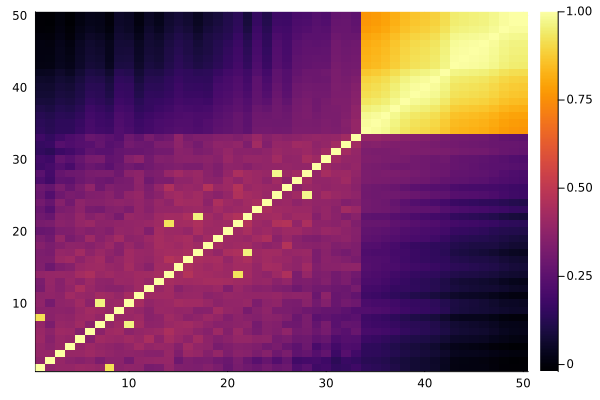

In [85]:
heatmap(sxo[:,:,1],)

In [86]:
copy_hd = map(x -> attach_positions(x, posn), copy_hd);

In [184]:
q_template = reverse(reshape(posn, n_hd, 50, 1), dims=2);

In [185]:
qs = repeat(q_template, 1,1,1000);

In [186]:
size(qs)

(512, 50, 1000)

In [187]:
xs = [x[1] for x in copy_hd] |> stack
ys = [x[2] for x in copy_hd] |> stack;

In [188]:
using MLUtils: BatchView

In [189]:
train_set = BatchView((xs, ys, qs), batchsize= 32)

BatchView(([0.011557519435882568 0.13897221326828 … 0.4350615930557251 0.43950099706649787; -0.38842761516571045 0.008654342889785779 … -0.16534385442733765 -0.16703103661537175; … ; -0.7900009473044541 -0.21201094269752502 … -0.3824817681312561 -0.3863846433162689; 0.24970555305480957 0.17388296842575082 … -0.40813995838165296 -0.4021005702018738;;; -0.014318645000457732 0.11020504474639889 … 0.4350615930557251 0.43950099706649787; -0.6233502348143724 0.021380590200424206 … -0.16534385442733765 -0.16703103661537175; … ; -0.7234447320181993 -0.0661774504184723 … -0.3824817681312561 -0.3863846433162689; 0.6616026759147644 0.16764295816421515 … -0.40813995838165296 -0.4021005702018738;;; 0.8264740427214768 0.5695961022377014 … 0.4350615930557251 0.43950099706649787; -0.26988965272903437 -0.07628591179847717 … -0.16534385442733765 -0.16703103661537175; … ; -0.20946073532104492 -0.582861088514328 … -0.3824817681312561 -0.3863846433162689; 0.23847639560699463 0.6294230294227601 … -0.4081399

In [190]:
b = first(train_set);

In [191]:
length(b)

3

In [192]:
x = b[1] |> gdev
y = b[2] |> gdev;
q = b[3] |> gdev;

In [193]:
size(x)

(512, 50, 32)

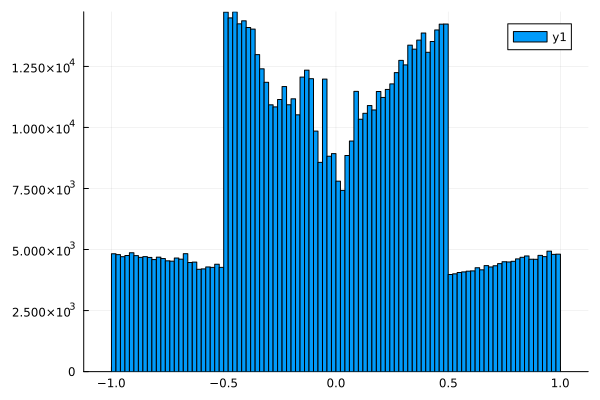

In [194]:
histogram(vec(x |> cdev))

In [195]:
size(x)

(512, 50, 32)

In [196]:
size(y)

(512, 50, 32)

In [197]:
size(q)

(512, 50, 32)

# Test without correction block

In [198]:
l = PhasorAttention(3.0f0)

PhasorAttention(3.0f0)  # 1 parameters

In [199]:
ps, st = Lux.setup(rng, l) .|> gdev

((scale = Float32[3.0],), NamedTuple())

In [200]:
yh, sc = l(q, x, x, ps, st)

(Float32[0.4907058 0.48860094 … 0.4723284 0.47130615; -0.18323001 -0.18273167 … -0.19541027 -0.19547373; … ; -0.40743586 -0.40645558 … -0.39894003 -0.39860573; -0.5914281 -0.5854325 … 0.7775905 0.775964;;; 0.3738363 0.37132794 … 0.3426094 0.34281084; -0.14290792 -0.14199162 … -0.13894926 -0.13913052; … ; -0.3260166 -0.32364964 … -0.29003334 -0.29024944; -0.21282935 -0.14989406 … 0.41396934 0.41397214;;; 0.44257993 0.44338214 … 0.59607506 0.59615064; -0.1380754 -0.13795795 … -0.12878247 -0.12884885; … ; -0.36268798 -0.36274797 … -0.35857546 -0.35840207; -0.54312795 -0.547048 … 0.6425648 0.64164966;;; … ;;; 0.44335747 0.44427392 … 0.43322906 0.43299764; -0.17328034 -0.1742097 … -0.120396376 -0.11986349; … ; -0.4120768 -0.41306102 … -0.48906505 -0.48840317; -0.59009993 -0.5978427 … 0.69406074 0.6936267;;; 0.4558522 0.4559228 … 0.5794312 0.57888037; -0.16850652 -0.1686019 … -0.16724919 -0.16706713; … ; -0.3693206 -0.36939877 … -0.37724298 -0.3767882; -0.5261581 -0.52671707 … 0.7396893 0.73

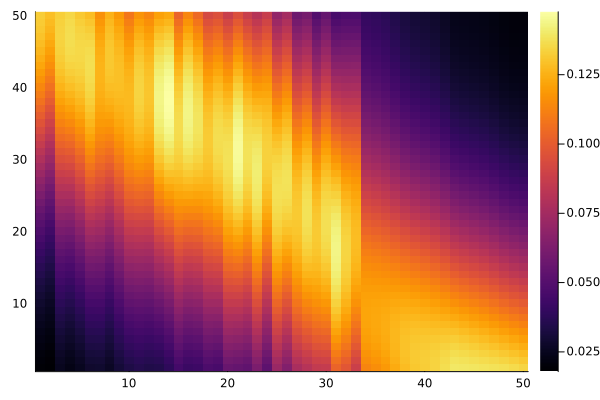

In [201]:
heatmap(sc.scores[:,:,1] |> cdev)

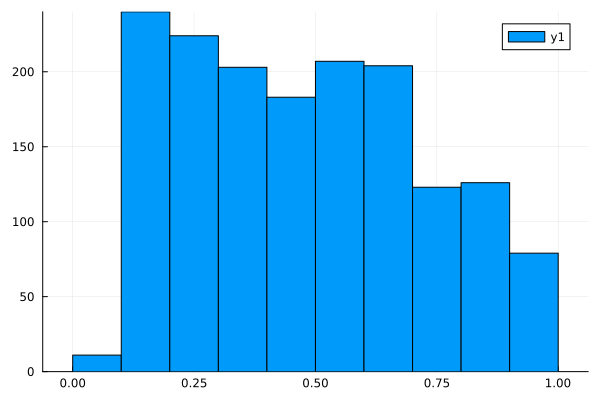

In [202]:
histogram(vec(similarity(yh, x) |> cdev))

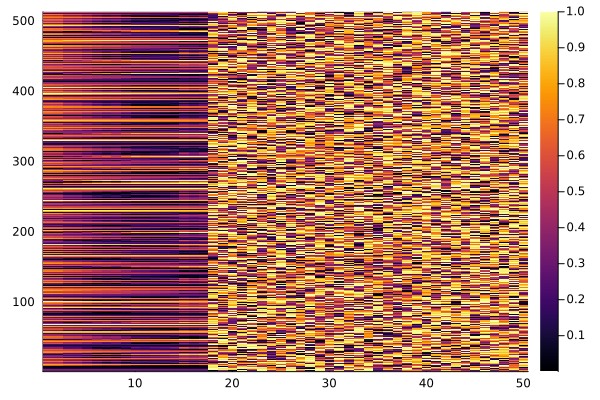

In [204]:
heatmap(abs.(arc_error(yh .- y)[:,:,1]) |> cdev)

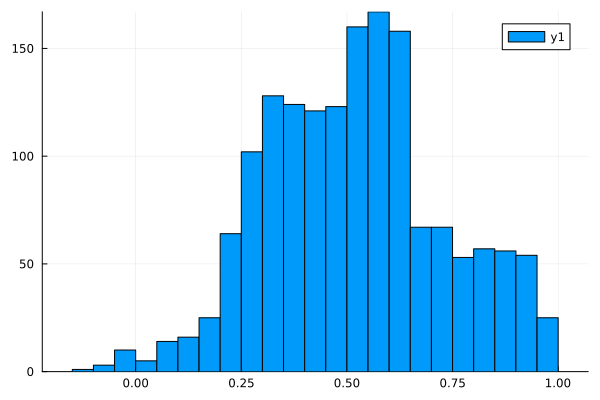

In [205]:
histogram(vec(similarity(yh, y)[mask] |> cdev))

In [131]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = true   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [206]:
function train(model, ps, st, train_loader, loss, args; verbose::Bool = false)
    if CUDA.functional() && args.use_cuda
       @info "Training on CUDA GPU"
       #CUDA.allowscalar(false)
       device = gpu_device()
   else
       @info "Training on CPU"
       device = cpu_device()
   end

   ## Optimizer
   opt_state = Optimisers.setup(Adam(args.η), ps)
   losses = []

   ## Training
   for epoch in 1:args.epochs
       for (x, y, q) in train_loader
           x = x |> device
           y = y |> device
           q = q |> device
           
           lf = p -> loss(q, x, y, model, p, st)
           lossval, gs = withgradient(lf, ps)
           if verbose
               println(reduce(*, ["Epoch ", string(epoch), " loss: ", string(lossval)]))
           end
           append!(losses, lossval)
           opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
       end
   end

   return losses, ps, st
end

train (generic function with 1 method)

In [207]:
function at_loss_prototype(q, x, y, model, p, st)
    yh, _ = model(q, x, x, p, st)
    return mean(similarity_loss(y, yh))
end

at_loss_prototype (generic function with 1 method)

In [208]:
args = Args(epochs=1);

In [209]:
at_loss_prototype(q, x, y, l, ps, st)

0.48094202842214145

In [210]:
withgradient(p -> at_loss_prototype(q, x, y, l, p, st), ps)

(val = 0.48094202842214145, grad = ((scale = Float32[0.016071135],),))

# Test with correction block

In [211]:
import .PhasorNetworks: SingleHeadAttention, identity_layer

## Sub-test for residual block identity check

In [212]:
rb = ResidualBlock((n_hd, Int(n_hd/2), n_hd));

In [213]:
psr, str = Lux.setup(rng, rb) .|> gdev

((ff = (layer_1 = (weight = Float32[-0.05207078 0.015946653 … 0.013474114 -0.08049926; 0.02269145 0.04923428 … -0.027888432 0.020220827; … ; 0.05816632 0.021934915 … -0.090523824 0.015136763; -0.04052058 0.07146276 … -0.045087937 -0.01833949], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.0133547215 0.007640499 … -0.015944181 0.00062471; 0.061409023 -0.0031158044 … 0.119359575 -0.036580343; … ; -0.028908953 0.09035012 … 0.0051571825 -0.02715979; 0.049843494 -0.00909779 … -0.04039851 0.03383265], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])),), (ff = (layer_1

In [214]:
function rb_loss_prototype(q, x, y, model, p, st)
    yh, _ = model(x, p, st)
    return mean(similarity_loss(y, yh))
end

rb_loss_prototype (generic function with 2 methods)

In [215]:
mlp = rb.ff

Chain(
    layer_1 = PhasorDense((512, 256)),  # 131_584 parameters
    layer_2 = PhasorDense((256, 512)),  # 132_096 parameters
)         # Total: 263_680 parameters,
          #        plus 0 states.

In [216]:
CUDA.allowscalar(false)

In [217]:
yr = rb(x, psr, str);

In [218]:
ym, _ = mlp(x, psr.ff, str.ff);

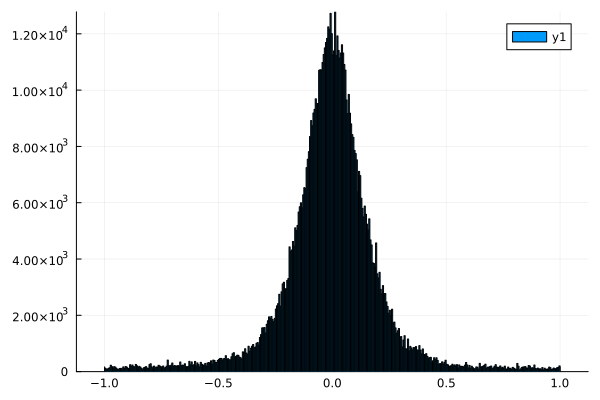

In [219]:
histogram(vec(cdev(ym)))

In [220]:
size(yr[1])

(512, 50, 32)

In [221]:
rb_loss_prototype(q, x, y, rb, psr, str)

0.5796791041105827

In [222]:
lv, gs = withgradient(p ->  rb_loss_prototype(q, x, y, rb, p, str), psr)

(val = 0.5796791041105827, grad = ((ff = (layer_1 = (weight = Float32[-9.479561f-5 0.00022257012 … 0.00011475112 9.772072f-5; -0.00017534017 0.00044848214 … 0.00043093658 2.298443f-5; … ; -4.356983f-5 0.00010914496 … 6.477086f-5 -2.9610444f-5; -0.000104622915 3.0484009f-5 … 0.00010722849 3.140262f-5], bias_real = Float32[0.00016998616, 2.6437723f-5, 1.5221547f-5, -0.00032859403, -0.00043777132, 6.163948f-5, 0.0004361535, 0.0004506362, -0.00019826426, -0.00021059035  …  7.3540425f-5, 9.4459665f-6, 0.00016315776, -0.0002894402, 0.00019338826, 7.953585f-5, -4.741663f-5, -0.00023944638, 9.516539f-5, 3.979434f-5], bias_imag = Float32[-0.00012617082, -0.00053831685, -0.00021887431, -0.00020730853, -0.00046132138, 0.00013644752, -0.0004176887, -0.0005817369, 0.0004008392, -0.00027296756  …  1.10940255f-5, -0.00021646959, -0.00010773984, -0.00037124092, 0.00044530744, 4.1896452f-5, 0.00013253014, 0.0003419994, -0.000122050435, -0.000107373155]), layer_2 = (weight = Float32[-2.9594205f-5 -4.657

In [223]:
gs[1].ff.layer_2

(weight = Float32[-2.9594205f-5 -4.6570745f-5 … -2.1208458f-5 3.773089f-5; -0.0016676888 -0.0012463611 … -0.0017742716 -0.0013762525; … ; -1.4031655f-5 2.7708913f-5 … 1.5469132f-5 -5.6959823f-5; -4.770052f-5 6.208737f-5 … 4.4086886f-5 -0.00019483139], bias_real = Float32[1.989648f-5, -0.0017246772, -0.0003283992, -0.0007786055, -0.00013309422, -0.00042525298, -4.247739f-5, -0.00057441473, -0.00012717665, 2.0698837f-5  …  -0.00021247218, 1.1777036f-5, -0.002207784, 4.834465f-5, -8.661525f-5, -0.0017001492, -3.1493215f-5, -0.0044386424, -3.2228385f-5, -0.00014568107], bias_imag = Float32[-2.6769976f-5, -0.000563936, 0.00037702985, -0.00019671203, 0.00023670189, -0.00034375556, 7.087592f-5, -0.00065313326, 0.00023293588, 3.163354f-5  …  -0.00043950608, -3.745394f-6, -0.0010655448, -0.000245606, 0.0003839532, 0.0007745754, -8.04105f-5, -0.00026198296, 7.4870084f-5, 0.00047484474])

In [224]:
[sum(isnan.(x.weight)) / length(x.weight) for x in gs[1].ff]

2-element Vector{Float64}:
 0.0
 0.0

In [225]:
loss, pst = train(rb, psr, str, train_set, rb_loss_prototype, args)

[ Info: Training on CUDA GPU


(Any[0.5796791041105827, 0.5704961739018697, 0.5246157441793255, 0.5045391328757514, 0.5109364549996283, 0.5217148872076398, 0.5166498049413142, 0.48963310275449506, 0.529993803752824, 0.5243927895723154  …  0.46895326271292737, 0.503394244733804, 0.4578271784432444, 0.4703883566017535, 0.4380919343144396, 0.479422737792231, 0.4989758612619798, 0.46424406198929463, 0.4472916506550193, 0.4710005417261667], (ff = (layer_1 = (weight = Float32[-0.054343272 0.014522738 … 0.013972936 -0.086591914; 0.030195143 0.04316646 … -0.034342468 0.023425516; … ; 0.063408986 0.01780557 … -0.09360665 0.016226392; -0.03967049 0.07203996 … -0.04477477 -0.01985108], bias_real = Float32[0.9996738, 0.99324316, 1.0060427, 1.0036942, 0.99750215, 1.0031875, 0.9964483, 0.99882585, 1.0067449, 1.0033944  …  0.9986832, 1.0018643, 1.0022467, 1.0049661, 0.9981741, 1.0026907, 1.0028913, 1.002632, 0.99883235, 0.99917966], bias_imag = Float32[-0.0013922568, 0.007357521, 0.006757132, -0.0030437736, -0.0031740225, 0.001658

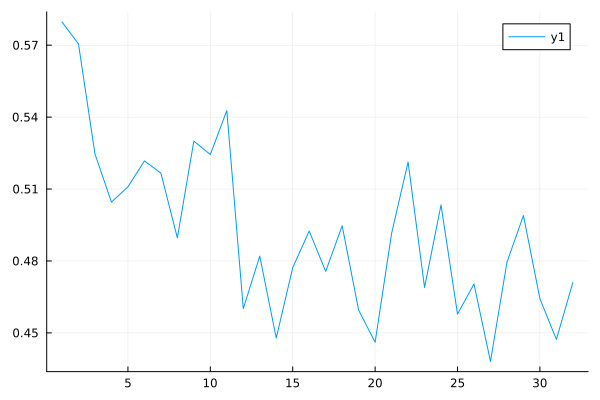

In [226]:
plot(loss)

# Att'n block

In [227]:
xf = SingleHeadAttention(n_hd, n_hd; q_proj=identity_layer, k_proj=identity_layer, v_proj=identity_layer, scale=6.0f0, out_proj=rb)

SingleHeadAttention(
    q_proj = Chain(
        layer_1 = WrappedFunction(#212),
    ),
    k_proj = Chain(
        layer_1 = WrappedFunction(#212),
    ),
    v_proj = Chain(
        layer_1 = WrappedFunction(#212),
    ),
    attention = PhasorAttention(6.0f0),  # 1 parameters
    out_proj = ResidualBlock(
        ff = Chain(
            layer_1 = PhasorDense((512, 256)),  # 131_584 parameters
            layer_2 = PhasorDense((256, 512)),  # 132_096 parameters
        ),
    ),
)         # Total: 263_681 parameters,
          #        plus 0 states.

In [228]:
xf.attention

PhasorAttention(6.0f0)  # 1 parameters

In [229]:
ps2, st2 = Lux.setup(rng, xf) .|> gdev

((q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = NamedTuple(),), attention = (scale = Float32[6.0],), out_proj = (ff = (layer_1 = (weight = Float32[-0.066107064 -0.050061315 … -0.045225803 -0.1018573; -0.030314937 0.010526424 … 0.049190074 -0.041951973; … ; -0.07984114 0.0813309 … -0.05387725 0.07065206; -0.029289931 0.060784258 … -0.046724185 -0.05650249], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.11716439 -0.0005357593 … 0.016464805 0.018932858; -0.06820484 0.047395915 … 0.008923606 -0.045670155; … ; 0.039969612 0.009322674 … 0.07094846 -0.0022404117; 0.040130615 0.072815195 … -0.039849784 -0.048884824], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [230]:
ps2.attention

(scale = Float32[6.0],)

In [231]:
st2.attention

NamedTuple()

In [232]:
typeof(ps2.attention.scale)

CuArray{Float32, 1, CUDA.DeviceMemory}

In [233]:
yh2, sc2 = xf(q, x, ps2, st2)

([0.5320562124252319 0.5243520736694336 … 0.393324613571167 0.3911632299423218; -0.3096466660499573 -0.3000261187553406 … -0.2497069239616394 -0.2480379343032837; … ; -0.3520810604095459 -0.3390226364135742 … -0.6250309944152832 -0.6262066960334778; -0.24910974502563477 -0.2657662630081177 … 0.3372812271118164 0.3324921131134033;;; 0.4104447364807129 0.39796769618988037 … 0.27252626419067383 0.2763746976852417; -0.2652561068534851 -0.264046311378479 … -0.01748555898666382 -0.018197238445281982; … ; -0.38874173164367676 -0.4014829993247986 … -0.3022831678390503 -0.2949046492576599; -0.11155140399932861 -0.09379565715789795 … 0.1198432445526123 0.11859714984893799;;; 0.4333304166793823 0.4336986541748047 … 0.6547378301620483 0.6564035415649414; -0.28381550312042236 -0.2850143313407898 … -0.0083235502243042 -0.009449541568756104; … ; -0.400762677192688 -0.3957951068878174 … -0.7030915021896362 -0.7019156813621521; -0.15933078527450562 -0.16357409954071045 … 0.396969199180603 0.39512062072

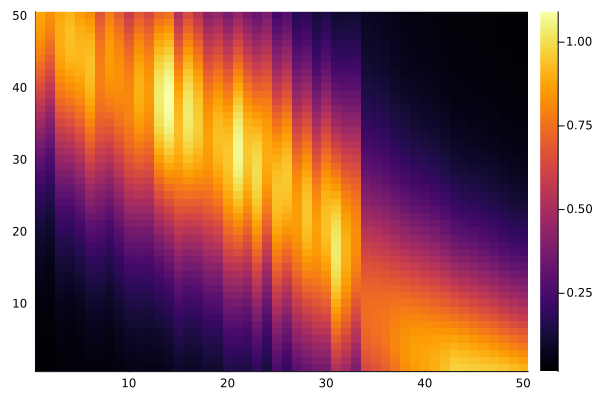

In [234]:
heatmap(sc2[1].scores[:,:,1] |> cdev)

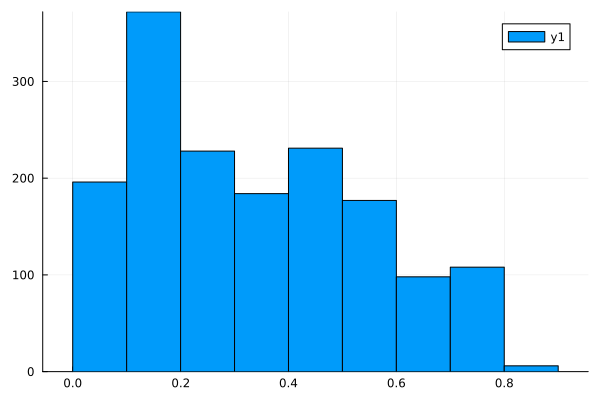

In [235]:
histogram(vec(similarity(yh2, x)) |> cdev)

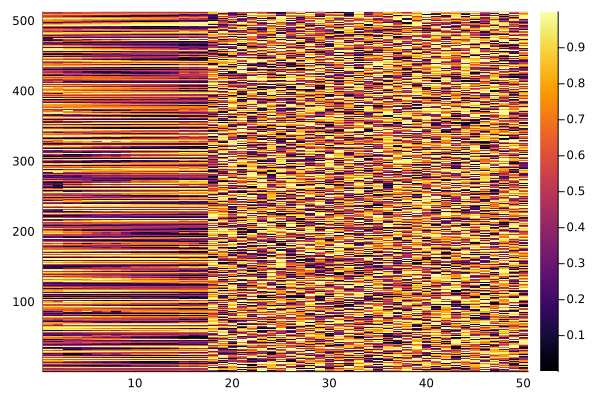

In [236]:
heatmap(abs.(arc_error(yh2 .- y)[:,:,1]) |> cdev)

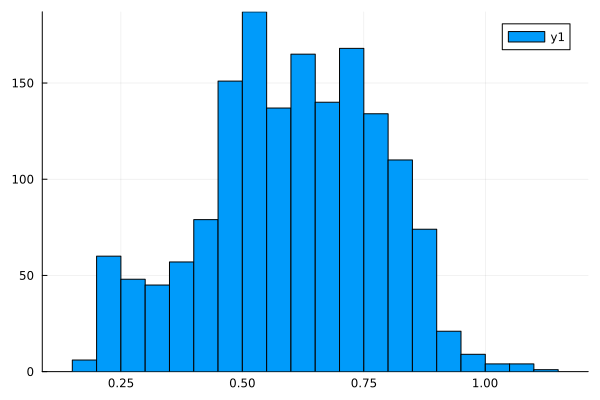

In [237]:
histogram(vec(similarity_loss(xf(q, x, ps2, st2)[1], y)) |> cdev)

In [238]:
loss, gs = withgradient(p -> mean(similarity_loss(xf(q, x, p, st2)[1], y)), ps2)

(val = 0.601806332305038, grad = ((q_proj = nothing, k_proj = nothing, v_proj = nothing, attention = (scale = Float32[0.0072155623],), out_proj = (ff = (layer_1 = (weight = Float32[0.00020773995 -0.00046412664 … -0.00039882146 0.00018402484; 0.0006778718 0.0013915721 … 0.00038508215 0.00049510994; … ; 0.00034948497 -0.0003106752 … -0.00028073642 -0.00013459474; 0.00018428282 0.00040019574 … 0.0001717466 0.00017312214], bias_real = Float32[-0.00037205615, 0.0016851102, -0.00017844552, 0.000103957995, 0.00016650342, -0.00012958507, -0.00083582767, -0.00096738304, -0.00015176054, 8.930375f-5  …  -1.1445866f-7, -2.9613226f-5, 5.6740737f-5, -0.0002451009, -0.0001345471, 0.00028288862, 0.00021542513, 0.00027076446, -0.00013023992, 0.0004902519], bias_imag = Float32[0.00025933146, 0.0003529946, -6.9720154f-6, -7.552273f-5, 9.336887f-5, 0.0004880342, 2.150828f-5, -0.00062903675, 0.00096247444, -1.3850369f-5  …  0.00011665915, 0.0003176474, -0.00037996535, -0.00011842717, 0.00037925225, 0.00027

In [239]:
function loss_prototype(q, x, y, model, p, st)
    yh, _ = model(q, x, p, st)
    return mean(similarity_loss(y, yh))
end

loss_prototype (generic function with 2 methods)

In [240]:
loss_prototype(q, x, y, xf, ps2, st2)

0.601806332305038

In [241]:
loss, gs = withgradient(p -> loss_prototype(q, x, y, xf, p, st2), ps2)

(val = 0.601806332305038, grad = ((q_proj = nothing, k_proj = nothing, v_proj = nothing, attention = (scale = Float32[0.0072155623],), out_proj = (ff = (layer_1 = (weight = Float32[0.00020773995 -0.00046412664 … -0.00039882146 0.00018402484; 0.0006778718 0.0013915721 … 0.00038508215 0.00049510994; … ; 0.00034948497 -0.0003106752 … -0.00028073642 -0.00013459474; 0.00018428282 0.00040019574 … 0.0001717466 0.00017312214], bias_real = Float32[-0.00037205615, 0.0016851102, -0.00017844552, 0.000103957995, 0.00016650342, -0.00012958507, -0.00083582767, -0.00096738304, -0.00015176054, 8.930375f-5  …  -1.1445866f-7, -2.9613226f-5, 5.6740737f-5, -0.0002451009, -0.0001345471, 0.00028288862, 0.00021542513, 0.00027076446, -0.00013023992, 0.0004902519], bias_imag = Float32[0.00025933146, 0.0003529946, -6.9720154f-6, -7.552273f-5, 9.336887f-5, 0.0004880342, 2.150828f-5, -0.00062903675, 0.00096247444, -1.3850369f-5  …  0.00011665915, 0.0003176474, -0.00037996535, -0.00011842717, 0.00037925225, 0.00027

In [246]:
args.epochs = 5

5

In [247]:
loss, pst = train(xf, ps2, st2, train_set, loss_prototype, args)

[ Info: Training on CUDA GPU


(Any[0.601806332305038, 0.5839107725158265, 0.55454270069105, 0.5364553473858562, 0.5260447133875368, 0.5322141096920129, 0.4968782529461979, 0.4872352165657447, 0.4912381772215179, 0.5003332706608025  …  0.2716959841609624, 0.2768124176878605, 0.2658443266987936, 0.2642284107238544, 0.2569829841140894, 0.2634765046063711, 0.2789195781609683, 0.2707447680187028, 0.2626989704527103, 0.28302837585771706], (q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = NamedTuple(),), attention = (scale = Float32[5.981869],), out_proj = (ff = (layer_1 = (weight = Float32[-0.0660465 -0.043672416 … -0.042075656 -0.09560319; -0.04356683 -7.305963f-5 … 0.039535295 -0.055531688; … ; -0.07013595 0.083204255 … -0.057850428 0.08080648; -0.028257685 0.056912143 … -0.051146604 -0.04713997], bias_real = Float32[1.0081663, 0.9927002, 1.0008943, 0.99962276, 0.9935772, 1.0080941, 1.0006819, 1.0032523, 0.99983126, 1.0130978  …  1.0089105, 0.99158055, 1.0037944, 1.0048724, 1.

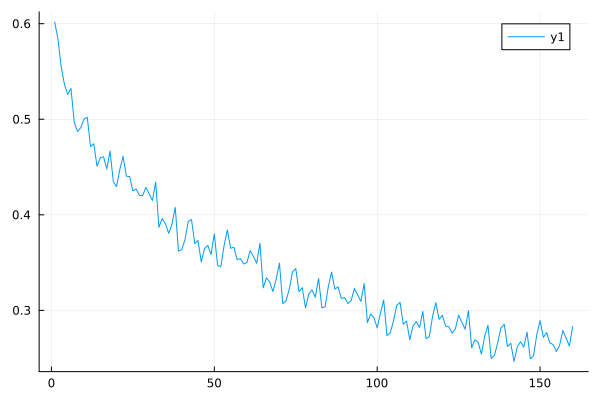

In [248]:
plot(loss)

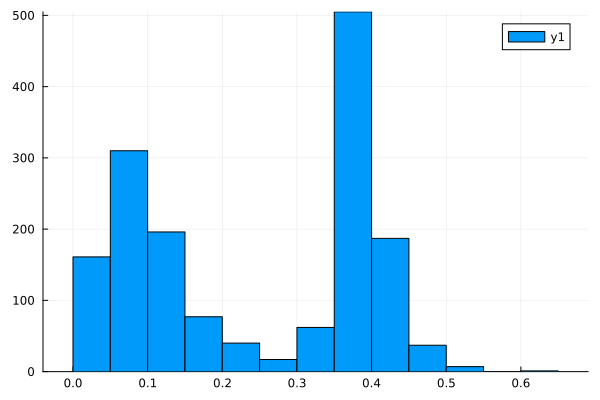

In [249]:
histogram(vec(similarity_loss(xf(q, x, pst, st2)[1], y)) |> cdev)

In [253]:
y2, _ = xf(q, x, pst, st2)

([0.2521096467971802 0.24556338787078857 … 0.7361463308334351 0.7344907522201538; -0.10395067930221558 -0.10535567998886108 … -0.30401575565338135 -0.30466461181640625; … ; -0.17766565084457397 -0.17784827947616577 … -0.7366683483123779 -0.7379508018493652; 0.3532288074493408 0.3639411926269531 … 0.9353232383728027 0.9298120737075806;;; 0.2086629867553711 0.20839977264404297 … 0.6548960208892822 0.6603901386260986; -0.09429723024368286 -0.10047078132629395 … -0.20929479598999023 -0.2119612693786621; … ; -0.1735484004020691 -0.19924324750900269 … -0.5076890587806702 -0.5085157155990601; 0.23777365684509277 0.2949596643447876 … -0.6356868743896484 -0.6500582695007324;;; 0.2639029026031494 0.26496434211730957 … -0.988548994064331 -0.9866089820861816; -0.09220659732818604 -0.0928388237953186 … -0.222556471824646 -0.22288525104522705; … ; -0.18016773462295532 -0.1815590262413025 … -0.710077166557312 -0.7114261388778687; 0.22660958766937256 0.227705717086792 … 0.9342066049575806 0.9318604469

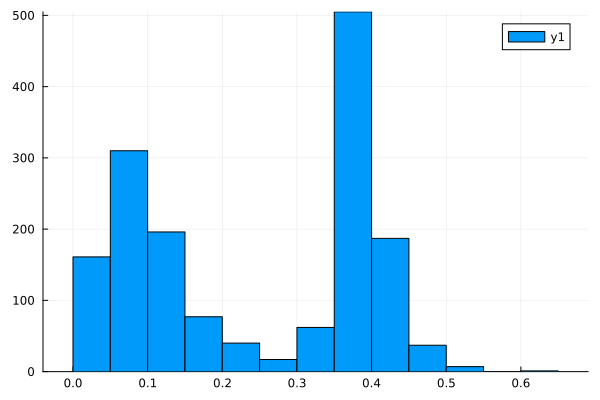

In [256]:
histogram(similarity_loss(y2, y) |> cdev |> vec)

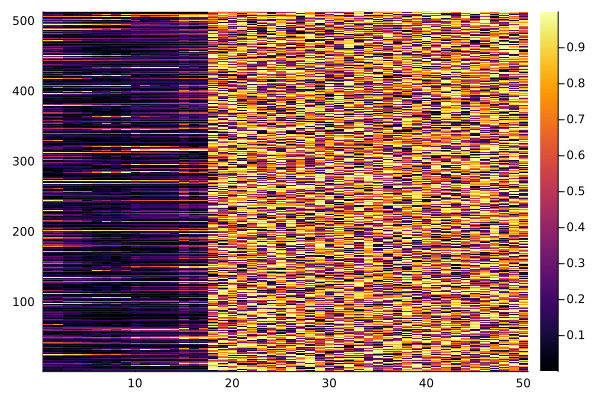

In [254]:
heatmap(abs.(arc_error(y2 .- y)[:,:,1]) |> cdev)